In [1]:
import _init_paths
from external.pytorch_pretrained_bert import BertTokenizer
import numpy as np
import json
import random
import os
import base64
import matplotlib.pyplot as plt
from PIL import Image
from bertviz.model_view import show
# from scipy.special import softmax
from pycocotools.coco import COCO
import glob

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [3]:
model_type = 'bert'
model_version = 'bert-base-uncased'
do_lower_case = True
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
# attention_folder = './data/attention_probs'
attention_folder = './data/attention_probs_rand100'
annotation_path = './data/coco/annotations/captions_val2017.json'
annotation_path_inst = './data/coco/annotations/instances_val2017.json'
image_folder = './data/coco/val2017'
coco = COCO(annotation_path)
coco_inst = COCO(annotation_path_inst)
all_img_ids = [int(os.path.basename(fn).split('.')[0]) for fn in glob.glob(os.path.join(attention_folder, '*.npy'))]

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [4]:
categories = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
              'trafficlight', 'firehydrant', 'stopsign', 'parkingmeter', 'bench', 'bird', 'cat', 'dog', 'horse',
              'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
              'suitcase', 'frisbee', 'skis', 'snowboard', 'sportsball', 'kite', 'baseballbat', 'baseballglove',
              'skateboard', 'surfboard', 'tennisracket', 'bottle', 'wineglass', 'cup', 'fork', 'knife', 'spoon',
              'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut',
              'cake', 'chair', 'couch', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tv', 'laptop', 'mouse',
              'remote', 'keyboard', 'cellphone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
              'clock', 'vase', 'scissors', 'teddybear', 'hairdrier', 'toothbrush']
json_id_to_class_id = {
    v: i + 1 for i, v in enumerate(coco_inst.getCatIds())
}
class_id_to_json_id = {
    v: k for k, v in json_id_to_class_id.items()
}
class_id_to_text = {i: text for i, text in enumerate(categories)}
def b64_decode(string):
    return base64.decodebytes(string.encode())

colors = [None] * 81
def show_image(image, boxes, class_ids, label_offsets=None):
    w, h = image.size
    if label_offsets is None:
        label_offsets = [(0, 0)] * len(boxes)
    plt.imshow(image)
    for i, (bbox, class_id, label_offset) in enumerate(zip(reversed(boxes), reversed(class_ids), reversed(label_offsets))):
        i_ = len(boxes) - i - 1
        if colors[class_id] is None:
            color = (random.random(), random.random(), random.random())
            while color in colors:
                color = (random.random(), random.random(), random.random())
            colors[class_id] = color
        else:
            color = colors[class_id]
        rect = plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=color, linewidth=1)
        plt.gca().add_patch(rect)
        plt.gca().text(max(bbox[0] + label_offset[0], 10), max(bbox[1] + label_offset[1] - 2, 18),
                       '{} {}'.format(i_ + 1, class_id_to_text[class_id]),
                       bbox=dict(facecolor=color, alpha=0.5), fontsize=5, color='white')
    plt.axis('off')
    plt.show()

def rescale(arr):
#     return (arr - arr.min())/(arr.max() - arr.min())
    return (arr - arr.min((1, 2, 3), keepdims=True))/(arr.max((1, 2, 3), keepdims=True) - arr.min((1, 2, 3), keepdims=True))

In [5]:
import matplotlib as mpl
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.5

image id: 527427
caption: a female is talking on the phone and a laptop on a table


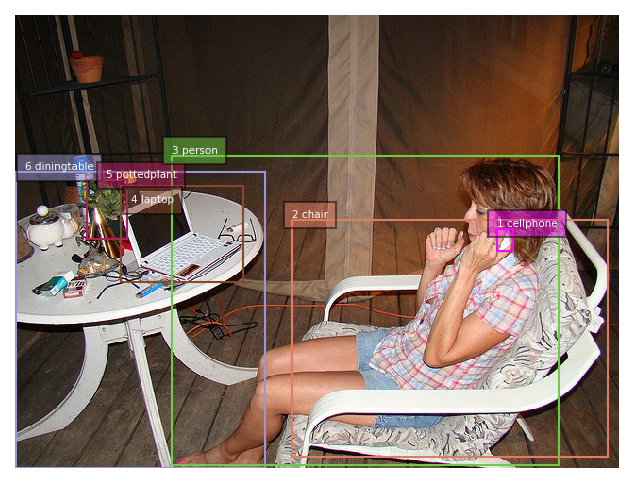

[(0, 0), (0, 0), (0, 0), (10, 20), (20, 0), (0, 0)]

In [6]:
# image_id = random.choice(all_img_ids)
# label_offsets = None

image_id = 527427
label_offsets = [(0, 0)] * 6
label_offsets[3] = (10, 20)
label_offsets[4] = (20, 0)

# image_id = 1268
# label_offsets = None

# image_id = 458255
# label_offsets = None

# image_id = 68093
# label_offsets = None

# image_id = 572900
# label_offsets = [(0, 0)] * 11
# label_offsets[4] = (-10, 0)
# label_offsets[5] = (0, 10)
# label_offsets[6] = (-35, -5)
# label_offsets[10] = (-20, 0)

# image_id = 281687
# label_offsets = None

# image_id = 373382
# label_offsets = [(0, 0)] * 16
# label_offsets[6] = (5, 25)
# label_offsets[15] = (0, 25)
# label_offsets[12] = (-60, 0)
# label_offsets[13] = (-5, 0)
# label_offsets[3] = (-15, 0)

ann_ids = coco.getAnnIds(imgIds=image_id)
anns = coco.loadAnns(ann_ids)
ann_ids_inst = coco_inst.getAnnIds(imgIds=image_id)
anns_inst = coco_inst.loadAnns(ann_ids_inst)
idb = anns[0]
boxes = [ann_['bbox'] for ann_ in anns_inst]
boxes = np.array(boxes).reshape(-1, 4)
TO_REMOVE = 1
xmin, ymin, w, h = np.split(boxes, 4, axis=-1)
xmax = xmin + (w - TO_REMOVE).clip(min=0)
ymax = ymin + (h - TO_REMOVE).clip(min=0)
boxes = np.concatenate((xmin, ymin, xmax, ymax), axis=-1)
classes = [ann["category_id"] for ann in anns_inst]
classes = [json_id_to_class_id[c] for c in classes]
path = coco_inst.loadImgs(image_id)[0]['file_name']
image = Image.open(os.path.join(image_folder, path)).convert('RGB')
caption = idb['caption']
print('image id: {}'.format(image_id))
print('caption: ' + caption)
show_image(image, boxes, classes, label_offsets=label_offsets)
label_offsets
# import _pickle
# with open('coco_cata_colors.pkl', 'wb') as f:
#     _pickle.dump(colors, f)

image id: 527427
caption: a female is talking on the phone and a laptop on a table


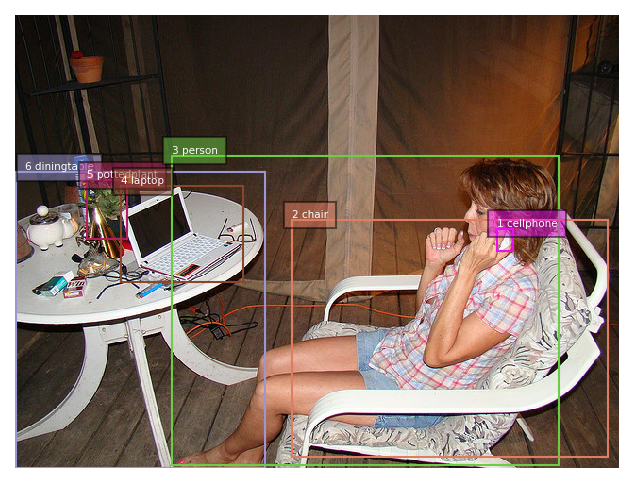

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
attn_arr = np.load(os.path.join(attention_folder, '{}.npy'.format(image_id)))
text_tokens = tokenizer.tokenize(caption)
bbox_tokens = [str(i+1) for i in range(attn_arr.shape[-1] - len(text_tokens) - 4)]
all_tokens = ['[CLS]'] + text_tokens + ['[SEP]'] + ['[IMG]'] + bbox_tokens +  ['[END]']
attn_arr_aa = attn_arr[:, :, 1:(1+len(text_tokens)), 1:(1+len(text_tokens))]
attn_arr_bb = attn_arr[:, :, (3+len(text_tokens)):-1, (3+len(text_tokens)):-1]
attn_arr_ab = attn_arr[:, :, 1:(1+len(text_tokens)), (3+len(text_tokens)):-1]
attn_arr_ba = attn_arr[:, :, (3+len(text_tokens)):-1, 1:(1+len(text_tokens))]
attn_arr_aa = rescale(attn_arr_aa)
attn_arr_bb = rescale(attn_arr_bb)
attn_arr_ab = rescale(attn_arr_ab)
attn_arr_ba = rescale(attn_arr_ba)
# attn_arr_aa = softmax(attn_arr_aa, axis=-1)
# attn_arr_bb = softmax(attn_arr_bb, axis=-1)
# attn_arr_ab = softmax(attn_arr_ab, axis=-1)
# attn_arr_ba = softmax(attn_arr_ba, axis=-1)
attn_data = {
    'all': {'attn': attn_arr.tolist(),
            'left_text': all_tokens,
            'right_text': all_tokens},
    'aa': {'attn': attn_arr_aa.tolist(),
           'left_text': text_tokens,
           'right_text': text_tokens},
    'bb': {'attn': attn_arr_bb.tolist(),
           'left_text': bbox_tokens,
           'right_text': bbox_tokens},
    'ab': {'attn': attn_arr_ab.tolist(),
           'left_text': text_tokens,
           'right_text': bbox_tokens},
    'ba': {'attn': attn_arr_ba.tolist(),
           'left_text': bbox_tokens,
           'right_text': text_tokens}
}
print('image id: {}'.format(image_id))
print('caption: ' + caption)
show_image(image, boxes, classes)
show(None, model_type, tokenizer, ' '.join(text_tokens), ' '.join(bbox_tokens), attn_data=attn_data)